In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import *

In [4]:
# from imblearn.combine import SMOTETomek
# from imblearn.under_sampling import TomekLinks
# from imblearn.over_sampling import RandomOverSampler

In [5]:
import optuna
from optuna import Trial
from optuna.samplers import TPESampler

In [6]:
from matplotlib import font_manager, rc
font_path = "C:/Windows/Fonts/malgun.ttf"
font = font_manager.FontProperties(fname = font_path).get_name()
rc('font', family = font)

### Getting Data

In [7]:
res = pd.read_csv('../Outputs/resampled.csv', encoding='cp949', index_col=0)
test = pd.read_csv('../Outputs/test_set.csv', encoding='cp949', index_col=0)
res = res.sample(frac=1).reset_index(drop=True)
test = test.sample(frac=1).reset_index(drop=True)

In [8]:
X_res, y_res = res.iloc[:, :-1], res.iloc[:, -1]
X_test, y_test = test.iloc[:, :-1], test.iloc[:, -1]

### Model Fitting

In [9]:
def objective(trial: Trial, X_train, y_train):
    params = {
        'max_depth':trial.suggest_int('max_depth', 3, 20),
        'min_samples_split':trial.suggest_int('min_samples_split', 5, 15)
    }
    
    dt_model = DecisionTreeClassifier(**params, random_state=42)
    dt_model.fit(X_train, y_train)
    if trial.should_prune():
        raise optuna.TrialPruned()

    y_pred = dt_model.predict(X_test)
    score = roc_auc_score(y_test, y_pred)                                               
    # score = cross_val_score(lg_model, X_train, y_train, cv=3, scoring='roc_auc').mean()
    
    return score

In [10]:
study =  optuna.create_study(direction='maximize', sampler=TPESampler())
study.optimize(lambda trial:objective(trial, X_res, y_res), n_trials=30)

[I 2024-06-05 18:12:54,021] A new study created in memory with name: no-name-3e59b914-06b3-4036-8116-58459afb3cd2
[I 2024-06-05 18:13:09,776] Trial 0 finished with value: 0.5811313498911983 and parameters: {'max_depth': 18, 'min_samples_split': 15}. Best is trial 0 with value: 0.5811313498911983.
[I 2024-06-05 18:13:17,298] Trial 1 finished with value: 0.5810481541232085 and parameters: {'max_depth': 8, 'min_samples_split': 10}. Best is trial 0 with value: 0.5811313498911983.
[I 2024-06-05 18:13:22,650] Trial 2 finished with value: 0.584412283334584 and parameters: {'max_depth': 11, 'min_samples_split': 12}. Best is trial 2 with value: 0.584412283334584.
[I 2024-06-05 18:13:27,588] Trial 3 finished with value: 0.5873805057402266 and parameters: {'max_depth': 12, 'min_samples_split': 5}. Best is trial 3 with value: 0.5873805057402266.
[I 2024-06-05 18:13:34,072] Trial 4 finished with value: 0.5793428753657988 and parameters: {'max_depth': 16, 'min_samples_split': 5}. Best is trial 3 wit

In [13]:
dt_model = DecisionTreeClassifier(**study.best_params, random_state=42)
dt_model.fit(X_res, y_res)

DecisionTreeClassifier(max_depth=15, min_samples_split=10, random_state=42)

### Making Predictions

In [14]:
y_pred = dt_model.predict(X_test)
y_pred_prob = dt_model.predict_proba(X_test)[:, 1]

### Plotting and Metrics

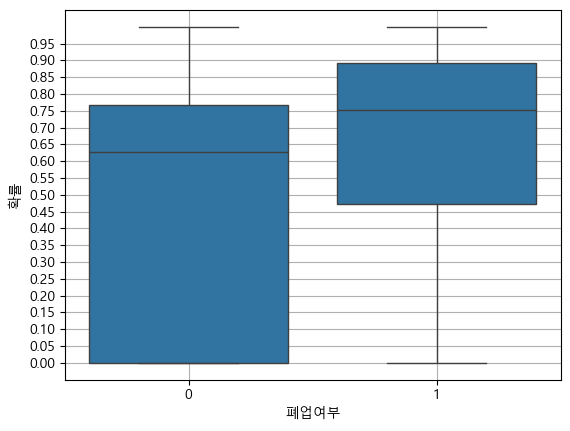

In [15]:
temp = pd.concat([pd.Series(y_test).rename('폐업여부'), pd.Series(y_pred_prob).rename('확률')], axis=1)
sns.boxplot(x='폐업여부', y='확률', data=temp)
plt.yticks(np.arange(0, 1, 0.05))
plt.grid(True)
plt.show()

In [23]:
print("0-1 proportion at test set :", y_test.value_counts().values)
print("accuracy score :", accuracy_score(y_test, y_pred))
print("precision score :", precision_score(y_test, y_pred))
print("recall score :", recall_score(y_test, y_pred))
print("f1_score :", f1_score(y_test, y_pred))
print("AUC score :", roc_auc_score(y_test, y_pred))

0-1 proportion at test set : [53308   800]
accuracy score : 0.6015191838545132
precision score : 0.020686152283326407
recall score : 0.56
f1_score : 0.03989847263659438
AUC score : 0.5810711337885496


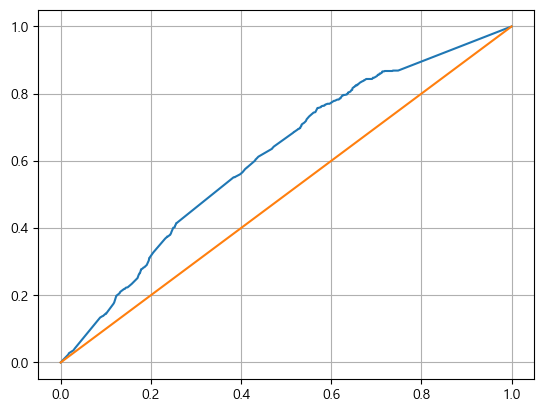

In [22]:
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
plt.plot(fpr, tpr, label = 'ROC')
plt.plot([0, 1], [0, 1])
plt.grid()
plt.show()

In [20]:
threshold = 0.70
y_pred = (y_pred_prob >= threshold).astype('int')

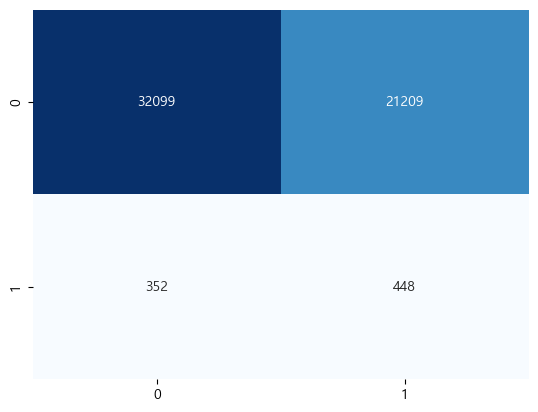

In [21]:
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, cbar = False, annot=True, cmap = 'Blues', fmt='g')
plt.show()

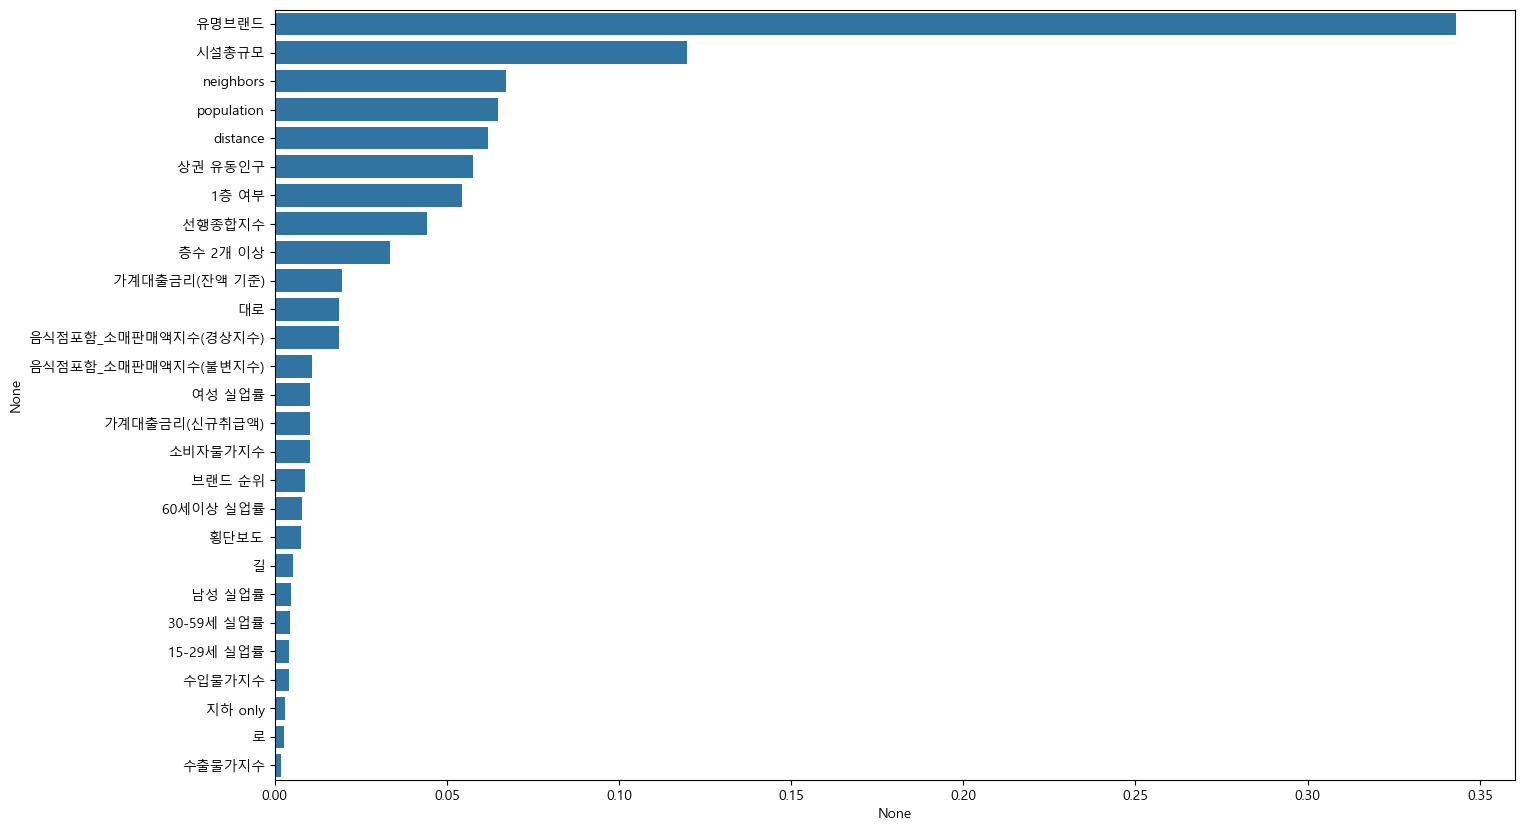

In [19]:
## Feature Importance
ser = pd.Series(dt_model.feature_importances_, index=X_res.columns)
ser = ser.sort_values(ascending=False)

plt.figure(figsize=(16, 10))
sns.barplot(x = ser, y=ser.index)
plt.show()